In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
import sys 
#sys.path.append("./models")
import numpy as np 
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm 
from data_loader import LoadPointsData2, LoadPointsDataTest2
from utils import EarlyStopping, LRScheduler
from network import Network2
from sklearn.model_selection import KFold

In [2]:
batch_size = 500
nepochs = 100
lr = 1e-04
use_lr_scheduler = True
start_epoch = 0

interval = 1
step_size = 1

num_seeds = "5000"
data_set = "gyre"
dim = 3

In [3]:
start_fm = 0
stop_fm = 512
num_fm  = stop_fm - start_fm
mode = 'long'
print("start fm and stop fm", start_fm, stop_fm)

start fm and stop fm 0 512


In [4]:
network = "network2"
num_encoder_layer = 3
num_decoder_layer = 6
latent_dim = 2048
model_dir = ""
boundings = np.loadtxt("./test/boundings_long_1.txt")
t_start = 0
t_end = (stop_fm - start_fm) * step_size * interval

In [5]:
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")
checkpoint_dir = os.path.join("checkpoints")

In [6]:
if not os.path.exists(os.path.join("checkpoints", data_set)):
    os.mkdir(os.path.join("checkpoints", data_set))
checkpoint_dir = os.path.join("checkpoints", data_set)

In [7]:
prefix = str(start_fm) + "_" + str(stop_fm) + "_" + data_set + "_" + num_seeds + "_" + network + "_" + str(latent_dim) + "_" + str(num_encoder_layer) + "_" + str(num_decoder_layer) 
if not os.path.exists(os.path.join(checkpoint_dir, prefix)):
    os.mkdir(os.path.join(checkpoint_dir, prefix))
checkpoint_dir = os.path.join(checkpoint_dir, prefix)

In [8]:
##! set seed 999
manualSeed = np.random.randint(0, 9999999, 1)
print("seed", manualSeed)
torch.manual_seed(manualSeed)
##! device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

seed [3673795]
device:  cuda


In [9]:
train_data_npy = np.load("../double_gyre/double_gyre_sobol_5000.npy")
train_dataset = LoadPointsDataTest2(train_data_npy, interval, num_fm, dim, boundings, t_start, t_end, step_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False)

In [10]:
print (train_dataloader.dataset[0])
print (len(train_dataset))
print (len(train_dataloader))
print (torch.cuda.device_count())

(tensor([-1., -1., -1.]), tensor([-1.0000, -1.0000, -0.9609]), tensor([-0.9961]))
2560000
5120
4


In [11]:
model = Network2(dim, num_encoder_layer, num_decoder_layer, latent_dim)
# print(model)
if model_dir != "":
    model.load_state_dict(torch.load(model_dir))
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model.to(device)

0 3 384
1 384 768
2 768 1536
0 1 128
1 128 256
2 256 512
0 2048 2048
1 2048 1024
2 1024 512
3 512 256
4 256 128
5 128 3


DataParallel(
  (module): Network2(
    (pos_encoder): ModuleList(
      (0): To_Latent()
      (1): Sine()
      (2): To_Latent()
      (3): Sine()
      (4): To_Latent()
    )
    (activation): Sine()
    (fc_encoder): ModuleList(
      (0): To_Latent()
      (1): Sine()
      (2): To_Latent()
      (3): Sine()
      (4): To_Latent()
    )
    (decoder): ModuleList(
      (0): To_Latent()
      (1): Sine()
      (2): To_Latent()
      (3): Sine()
      (4): To_Latent()
      (5): Sine()
      (6): To_Latent()
      (7): Sine()
      (8): To_Latent()
      (9): Sine()
      (10): To_Latent()
      (11): Sine()
    )
  )
)

In [12]:
L1_loss = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-06)

if use_lr_scheduler:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)

INFO: Initializing learning rate scheduler


In [13]:
start_time = torch.cuda.Event(enable_timing=True)
end_time = torch.cuda.Event(enable_timing=True)

train_loss = []
# test_loss =[]

In [14]:
start_time.record()

for epoch in range(start_epoch, start_epoch + nepochs):
    avg_train_loss = 0
    # train_bar = tqdm(enumerate(train_dataloader))
    model.train()
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    for i, data in tqdm(enumerate(train_dataloader)):
    # for i, data in enumerate(train_dataloader):
    #enumerate(tqdm(train_dataloader)):
        start = data[0].to(device)
        end = data[1].to(device)
        t = data[2].to(device)

        model.zero_grad()
        pred = model(start, t)
        loss = L1_loss(pred, end)
        loss.backward()
        optimizer.step()
        avg_train_loss = avg_train_loss + loss.item()

    train_loss.append(avg_train_loss / len(train_dataloader))
    print("Average Train Loss:", epoch, avg_train_loss / len(train_dataloader))

    if (epoch + 1) % 50 == 0:
        
        # save model 
        path = os.path.join(checkpoint_dir, "model_" + str(epoch+1) + ".pth")
        if torch.cuda.device_count() > 1:
            torch.save(model.module.state_dict(), path)
        else:
            torch.save(model.state_dict(), path)
 
end_time.record()

torch.cuda.synchronize()
train_path = os.path.join(checkpoint_dir, "train_loss.npy")
np.save(train_path, train_loss)
# test_path = os.path.join(checkpoint_dir, "test_loss.npy")
# np.save(test_path, test_loss)

0.0001


5120it [02:36, 32.72it/s]


Average Train Loss: 0 2.8905999556183817
0.0001


5120it [02:33, 33.40it/s]


Average Train Loss: 1 2.8402232055552306
0.0001


5120it [02:32, 33.51it/s]


Average Train Loss: 2 2.8231762636918574
0.0001


1471it [00:43, 33.67it/s]


KeyboardInterrupt: 

In [2]:
from matplotlib import pyplot as plt
import numpy as np 

In [87]:
train_data_npy = np.load("../double_gyre/double_gyre_sobol_5000.npy")
print(train_data_npy.shape)

(513, 5000, 3)


In [4]:
print(train_data_npy[2,:,:])

[[0.        0.        0.0391389]
 [0.999997  0.48771   0.0391389]
 [1.50869   0.250056  0.0391389]
 ...
 [1.12434   0.937262  0.0391389]
 [1.6382    0.192254  0.0391389]
 [0.635178  0.68542   0.0391389]]


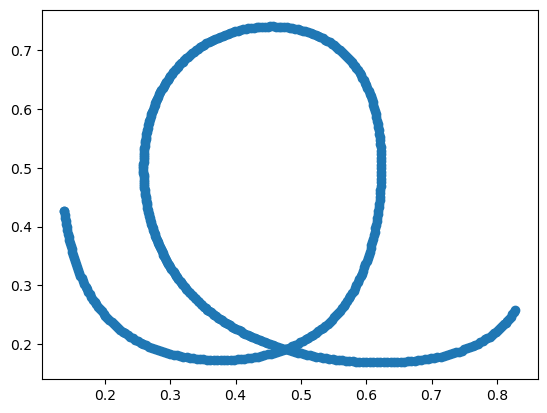

In [6]:
plt.scatter(train_data_npy[:,100,0],train_data_npy[:,100,1])